In [16]:
import pandas as pd
import numpy as np
import seaborn as sb
from scipy.fftpack import fft, fftfreq, fftshift
from scipy import signal
import matplotlib.pylab as plt
%matplotlib inline

In [41]:
data1 = pd.read_csv("pulse_K1=-4500.csv")
data1 = data1[[' Oxs_TimeDriver::Simulation time (s)', ' Oxs_TimeDriver::mz']]
data1.columns = ['Time', 'mz']

In [42]:
data1['Time'] = data1['Time'].str.strip()
data1['mz'] = data1['mz'].str.strip()
data1['Time'] = pd.to_numeric(data1['Time'], errors='coerce')
data1['mz'] = pd.to_numeric(data1['mz'], errors='coerce')
data1 = data1.dropna()

In [54]:
peakind = signal.find_peaks_cwt(data1['mz'], np.arange(1,80))
peaks = []
x_peaks = []
for index in peakind:
    x_peaks.append(data1['Time'][index])
    peaks.append(data1['mz'][index])

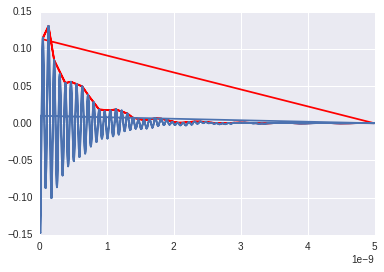

In [56]:
plt.plot(x_peaks, peaks, c='r')
plt.plot(data1['Time'], data1['mz'])

In [44]:
dt = data1['Time'][1] - data1['Time'][0]
n = len(data1['mz']) 
mz_fft = fft(data1['mz'])
freq = fftfreq(n, dt)

#Shift frequencies
#mz_fft_shifted = np.fft.fftshift(mz_fft)
#freq_shifted = np.fft.fftshift(freq)

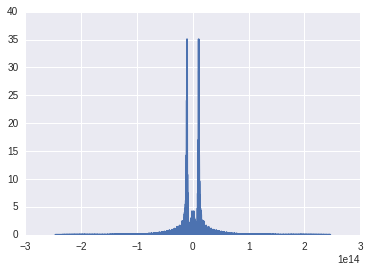

In [45]:
plt.plot(freq, abs(mz_fft))

In [46]:
max_freq = freq[mz_fft.argmax()]
print('The dominating frequency is {0:.3g} Hz'.format(max_freq))

The dominating frequency is 1.13e+13 Hz


In [47]:
peakind = signal.find_peaks_cwt(abs(mz_fft), np.arange(1,80))
peaks = []
x_peaks = []
for index in peakind:
    x_peaks.append(freq[index])
    peaks.append(abs(mz_fft[index]))
    
    
    

(0, 20000000000000.0)

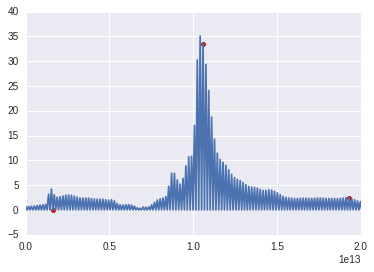

In [51]:
plt.scatter(x_peaks, peaks, c='r')
plt.plot(freq_shifted, abs(mz_fft_shifted))
plt.xlim(0, 0.2e14)